In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
import cv2 #this needs to be imported before TF!!
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from six.moves import map

%matplotlib inline

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'
class_names = pd.read_csv('traffic-signs-data/signnames.csv')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Data Summary and Exploration


Below I show a sample for each class in the dataset. There are 43 unique classes. Some classes (particularly the speed limit signs) are overrepresented in the dataset. We might need to revisit this class imbalance problem later to improve the accuracy.

In all, the training data and test data consist of 39209 and 12630 images, respectively. The images are of size 32x32.  

In [3]:
n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = X_train.shape[1:]
NB_CLASSES = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", NB_CLASSES)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
#################
#  Parameters   #
#################

base_image_path = "traffic-signs-data/"
IMAGE_SIZE = 32
# number of epochs
NB_EPOCHS = 100
NB_TRAIN_SAMPLES = 50000
# batch size
BATCH_SIZE = 128
checkpoint_name = "model.ckpt"
# filter size
FILTER_SIZE = 3
#number of conv filters
NB_FILTERS = 16
#input channels
INPUT_CHANNELS = 3
# number of hidden layers
NB_HIDDEN = 128
# Learning Rate
LR = 0.001

In [ ]:
y = pd.DataFrame(y_train,columns=['label'])
y['value'] = y.index
ix = np.array(y.groupby('label').first())
ix = np.squeeze(ix)
X_sample = X_train[ix,:,:,:]
im_grid = X_sample.shape[0] // 2
plt.figure(figsize=(300,300))
for i in range(NB_CLASSES):
    plt.subplot(im_grid, 4, i+1)
    plt.imshow(X_sample[i], aspect='auto')

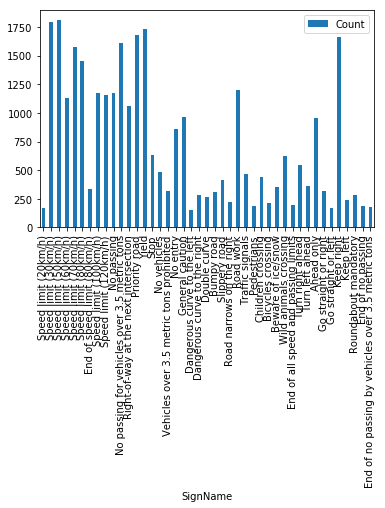

In [37]:
_y_dist = collections.Counter(y_train)
y_dist = pd.DataFrame.from_dict(_y_dist, orient='index').reset_index()
y_dist.columns = ['ClassId','Count']
y_dist = y_dist.merge(class_names, on='ClassId').drop('ClassId',axis=1)
y_dist.index = y_dist.SignName
plt.figure(figsize=(200,100))
y_dist.plot.bar()

In [38]:
y_classes =  y_dist.index.str.lower().tolist()
y_classes

['speed limit (20km/h)',
 'speed limit (30km/h)',
 'speed limit (50km/h)',
 'speed limit (60km/h)',
 'speed limit (70km/h)',
 'speed limit (80km/h)',
 'end of speed limit (80km/h)',
 'speed limit (100km/h)',
 'speed limit (120km/h)',
 'no passing',
 'no passing for vehicles over 3.5 metric tons',
 'right-of-way at the next intersection',
 'priority road',
 'yield',
 'stop',
 'no vehicles',
 'vehicles over 3.5 metric tons prohibited',
 'no entry',
 'general caution',
 'dangerous curve to the left',
 'dangerous curve to the right',
 'double curve',
 'bumpy road',
 'slippery road',
 'road narrows on the right',
 'road work',
 'traffic signals',
 'pedestrians',
 'children crossing',
 'bicycles crossing',
 'beware of ice/snow',
 'wild animals crossing',
 'end of all speed and passing limits',
 'turn right ahead',
 'turn left ahead',
 'ahead only',
 'go straight or right',
 'go straight or left',
 'keep right',
 'keep left',
 'roundabout mandatory',
 'end of no passing',
 'end of no passing 

## Preprocessing
The images are mean-substacted. Centering the input data around zero helps to allevaite dead or saturated neuron issues. I did not reduce the image to the gray-scale because it turns out that keeping the original three channel helps with the accuracy. This makes sense given that certain traffic signs have distinct colors associated with them. 

In addition, the main idea behind real-time data augmentation is to make the model more resistant to overfitting. By applying small distortions to the dataset, we implicitly force the model to generalize better. The `ImageGenerator` randomly flips the image horizontally and vertically, adds gaussian-blur, and distorts the brightness. The generator also allows us to run batches that are not confined to number of training examples in the dataset.

The data is split into training and validation, using a 80-20 split.

In [5]:
# Image Generation. Inspired by Keras image generation logic.
class ImageGenerator():
    
    def __init__(self, batch_size, x, y):
        self.x = x
        self.y = y
        self.batch_index = 0
        self.batch_size = batch_size
        self.N = len(x)
        self.index_generator = self._flow_index(self.N, batch_size, shuffle)
    
    # maintain the state
    def _flow_index(self, N, batch_size, shuffle=True):
        while 1:
            if self.batch_index == 0:
                index_array = np.arange(N)
            if shuffle:
                index_array = np.random.permutation(N)
                
            current_index = (self.batch_index * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = N - current_index
                self.batch_index = 0
            yield (index_array[current_index: current_index + current_batch_size],
               current_index, current_batch_size) 
            
    def __iter__(self):
        return self
        
    def __next__(self):
        ix_array, current_index, current_batch_size = next(self.index_generator)
        batch_x = np.zeros(tuple([current_batch_size] + list(self.x.shape)[1:]))
        for i, j in enumerate(ix_array):
            x = self.x[j]
            x = self.transform(x)
            x = self.mean_substract(x)
            batch_x[i] = x
        batch_y = self.y[ix_array]
        return batch_x, batch_y
            
    def transform(self,x):
        x = self.random_flip(x)
        x = self.random_gaussian_blur(x)
        x = self.random_brightness(x)
        return x
                  
    def random_flip(self, x):
        if np.random.random() < 0.5:
            x = np.flipud(x)
        if np.random.random() < 0.5:
            x = np.fliplr(x)
        return x
    
    def random_gaussian_blur(self, img, kernel_size=3):
        if np.random.random() < 0.5:
            return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
        else:
            return img
    
    def random_brightness(self, img):
        image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        random_bright = .25 + np.random.uniform()
        image1[:,:,2] = image1[:,:,2] * random_bright
        image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
        return image1
    
    def mean_substract(self,img):
        return img - np.mean(img)

In [ ]:
# Image-flippin works as follows
_ix = 990
x1 = np.fliplr(X_train[_ix])
x2 = np.flipud(X_train[_ix])
plt.subplot(1, 3, 1)
plt.imshow(X_train[_ix], aspect='auto')
plt.subplot(1, 3, 2)
plt.imshow(x1, aspect='auto')
plt.subplot(1, 3, 3)
plt.imshow(x2, aspect='auto')

In [ ]:
# Denoising applies a gaussian filter to smooth out the data
x1 = cv2.GaussianBlur(X_train[_ix], (3, 3), 0)
plt.subplot(1, 2, 1)
plt.imshow(X_train[_ix], aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(x1, aspect='auto')


In [ ]:
# Random Brightness adjustment
image1 = cv2.cvtColor(X_train[_ix],cv2.COLOR_RGB2HSV)
random_bright = .25 + np.random.uniform()
image1[:,:,2] = image1[:,:,2] * random_bright
image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
               
plt.subplot(1, 2, 1)
plt.imshow(X_train[_ix], aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(image1, aspect='auto')

I split the data into training and validation, using a 80-20 split. 

In [6]:
train_test_split_ratio = 0.2
# Shuffle and split into validation / training
ix = list(range(n_train))
random.shuffle(ix)
X_train = X_train[ix,:]
y_train = y_train[ix]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= train_test_split_ratio , random_state=0)
print("the size of the training and validation data: {}, {}".format(X_train.shape[0], X_val.shape[0]))
NB_TRAIN_DATA = len(y_train)

the size of the training and validation data: 31367, 7842


Next, I normalize the image data.

In [7]:
# # Substacting the mean - applies to validation images
def mean_substract(img):
    return img - np.mean(img)

In [8]:
X_val_normalized = mean_substract(X_val)
# print("Shape for training data a {}".format(X_train_normalized.shape))
# print("Shape for validation data {}".format(X_val_normalized.shape))

In [ ]:
# plt.subplot(1, 2, 1)
# plt.imshow(X_train[150], aspect='auto')
# plt.subplot(1, 2, 2)
# plt.imshow(X_train_normalized[150][:,:,-1], aspect='auto')

# Model Architechture



I built a 3 layer CNN achitechture with filter size _3x3_. I have chosen `AdamOptimizer` as the optimizer. `AdamOptimizer` combines the logic of `AdaGrad` optimizer with momentum. In short, `AdaGrad` keeps track of historical sums of squares in each gradient, which is used to normalize the immediate gradient update. Momentum, in turn, allows a velocity to build up - very much like in physics along gradients. 

The batch size is set to _128_. A larger batch size is more stable, but takes a longer time to run. I have iterated over synthetic dataset through _50_ epochs, which seems to be adaquate enough to get to a detect error / accuracy rate. For each epoch, the data generator generates _50,000_ images randomly. Learning rate is set to _0.001_. The hyperparameters are mostly chosen by trial-and-error. One needs to be careful with peeking too much into the validation data however. 

Weights used in the convolutional layers were initialized using a truncated normal distribution with a standard deviation of _0.1_. Bias weights were either initialized to zeros or ones. Weights for the fully connected layers were initialized also using a truncated normal distribution with a standard deviation of _0.1_.

Image classes were transformed into one-hot encodings.

A reduced mean, cross entropy loss function was fed the logits from the last fully connected layer.

I experimented with couple of regularization techniques such as L2 or batch normalization. But it did not yield any significant improvement, hence excluded fromt the final version.






| Layer | Description   |
|-------|---------------|
|   Input   | 32x32x3 RGB Image - Normalized and Randomly Perturbed|
|   Convolution 3x3   | 16 filters. Same padding. 1x1 stride|
|   RELU   | |
|   Max Pooling   | 2x2 stride, kernel size of 2x2|
|   Convolution 3x3   | 16 filters. Same padding. 1x1 stride|
|   RELU   | |
|   Max Pooling   | 2x2 stride, kernel size of 2x2|
|   Fully Connected Layer   | 64 hidden layers|
|   Fully Connected Layer   | Softmax Layer. 43 classes|




In [9]:
#Reset the graph
tf.reset_default_graph()
graph = tf.get_default_graph()
assert [] == graph.get_operations()

In [10]:
#  Models.
def convNet(data):
    # Variables.
    # For saving and optimizer. 
    global_step = tf.Variable(0, name="global_step")
    
    # conv weights
    layer1_weights = tf.Variable(tf.truncated_normal(
      [FILTER_SIZE, FILTER_SIZE, INPUT_CHANNELS, NB_FILTERS], stddev=0.1), name="layer1_weights")
    layer1_biases = tf.Variable(tf.zeros([NB_FILTERS]), name="layer1_biases")
    layer2_weights = tf.Variable(tf.truncated_normal(
      [FILTER_SIZE, FILTER_SIZE, NB_FILTERS, NB_FILTERS], stddev=0.1), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[NB_FILTERS]), name="layer2_biases")

    # fully connected layers
    layer3_weights = tf.Variable(tf.truncated_normal(
      [IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * NB_FILTERS, NB_HIDDEN], stddev=0.1), name="layer3_weights")
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[NB_HIDDEN]), name="layer3_biases")
    layer4_weights = tf.Variable(tf.truncated_normal(
      [NB_HIDDEN, NB_CLASSES], stddev=0.1), name="layer4_weights")
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[NB_CLASSES]), name="layer4_biases")
    
    # 1st Convolution
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    # Relu activation of conv
    hidden = tf.nn.relu(conv + layer1_biases)
    # Max pooling of activation
    hidden_pooled = tf.nn.max_pool(hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    #print(hidden_pooled.get_shape())
    # 2nd Convolution
    conv = tf.nn.conv2d(hidden_pooled, layer2_weights, [1, 1, 1, 1], padding='SAME')
    # Relu activation of conv
    hidden = tf.nn.relu(conv + layer2_biases)
    # Max pooling
    hidden_pooled = tf.nn.max_pool(hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    #print(hidden_pooled.get_shape())
    # Flatten
    shape = hidden_pooled.get_shape().as_list()
    reshape = tf.reshape(hidden_pooled, [-1, shape[1] * shape[2] * shape[3]])
    # 1st fully connected layer with relu activation
    #print(reshape.get_shape())
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    # 2nd fully connected layer
    return tf.matmul(hidden, layer4_weights) + layer4_biases

print('done')

done


In [11]:
# Placeholders.
tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step")
x = tf.placeholder(
    tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, INPUT_CHANNELS),name='x')
y = tf.placeholder(tf.int32, shape=(None),name='y')
one_hot_y = tf.one_hot(y, NB_CLASSES)

In [12]:
# Set the graph computations.
logits = convNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LR)
training_operation = optimizer.minimize(loss_operation)

Setting up the final ops and evaluation function for validation accuracy.

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

done


In [14]:
gr = tf.get_default_graph()
print("Number of ops in TF Graph is {}".format(len(gr.get_operations())))

Number of ops in TF Graph is 429


This is where we finally train our model.

In [15]:
#Initiate the generator
gen = ImageGenerator(BATCH_SIZE, X_train, y_train)

In [41]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    print("Training...")
    print()
    for i in range(1):
        #X_train_gray, y_train = shuffle(X_train_gray, y_train)
        for offset in range(0, NB_TRAIN_SAMPLES, BATCH_SIZE):
            #end = offset + BATCH_SIZE
            #batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            batch_x, batch_y = next(gen)
            _, l = sess.run([training_operation, loss_operation] , feed_dict={x: batch_x, y: batch_y})
        
        print("Epoch {} ...".format(i+1))
        validation_accuracy = evaluate(X_val_normalized, y_val)
        print("Training Loss = {:.3f}".format(l))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    # Save the variables to disk.
    save_path = saver.save(session, base_image_path + checkpoint_name)
    print("Model saved in file: %s" % save_path)

Training...

Epoch 1 ...
Training Loss = 1.903
Validation Accuracy = 0.304



NameError: name 'session' is not defined

In [40]:
base_image_path + checkpoint_name

'traffic-signs-data/model.ckpt'

In [22]:
#Test Accuracy
X_test_normalized = mean_substract(X_test)
with tf.Session() as sess:
    validation_accuracy = evaluate(X_test_normalized, y_test)
    print("Validation Accuracy for Test Data = {:.3f}".format(validation_accuracy))

Validation Accuracy for Test Data = 0.020


33

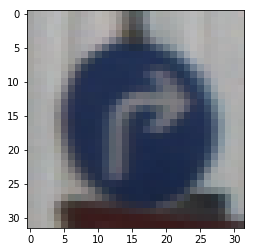

In [36]:
_ix = 99
plt.imshow(X_test[_ix])
y_test[_ix]

The validation set accuracy, test set. 

I tried several architechtures including LeNet but ended up settling with a plain-vanilla ConvNet architecture because it led to a higher accuracy rate out of the box. The hyperparameter space is very very large even for a single model. Comparing multiple models adds to the complexity of the hand-tuning the parameters.

The convergence takes longer with distorted images. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.